# Morphology Tutorial
Morphology sub-package functions can be used with a clean mask of a plant (see VIS tutorial for examples of masking background. This tutorial will start with a binary mask (after object segmentation has been completed) but in a complete workflow users will need to use other functions to achieve plant isolation. Skeletonizing is very sensitive to any pepper noise remaining within a binary mask. Morphology functions are intended to be one type of object analysis. These functions can potentially return information about leaf length, leaf angle, and leaf curvature.

In [1]:
# Import libraries
from plantcv import plantcv as pcv 
import numpy as np
import cv2

In [2]:
class options:
    def __init__(self):
        self.image = "C:/Users/Beth/Downloads/14-24-00.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./morphology_tutorial_results_FRM2.json"
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

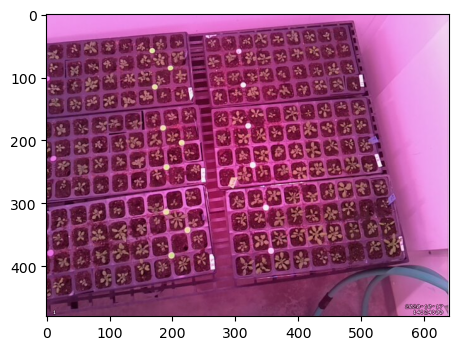

In [3]:
# Read image (sometimes you need to run this line twice to see the image) 

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)


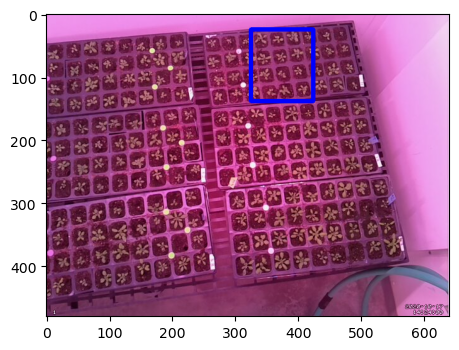

In [4]:
# Crop image
crop_img = pcv.crop(img=img, x=325, y=24, h=115, w=100)

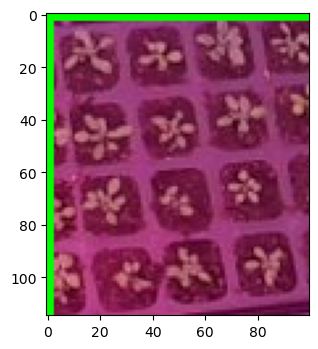

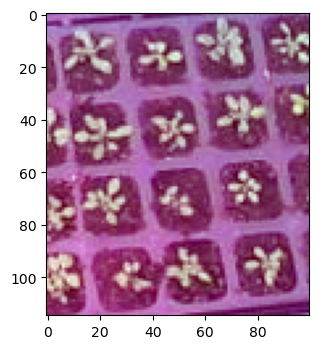

In [5]:
# Check if this is a night image, for some of these dataset's images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass

# Normalize the white color so you can later
# compare color between images.

# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(crop_img, roi=(0,0,200,200))

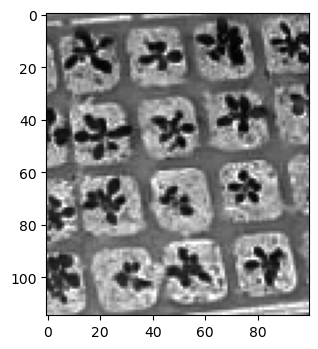

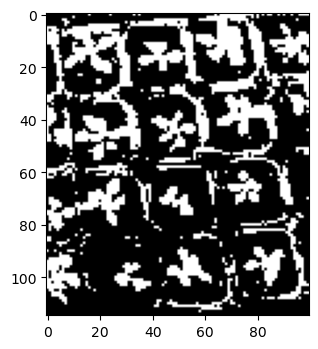

In [6]:
# Convert RGB to HSV and extract the saturation channel
# Then set threshold for saturation
s = pcv.rgb2gray_hsv(rgb_img=img1, channel='s')
s_thresh = pcv.threshold.binary(gray_img=s, threshold=90, max_value=255, object_type='dark')

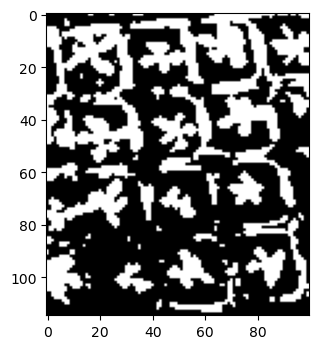

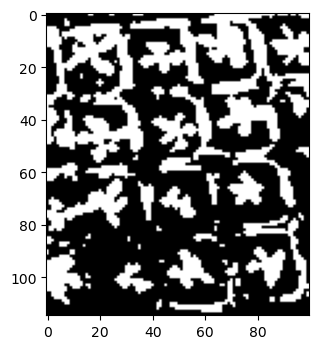

In [7]:
# Set Median Blur
#Input box size "ksize" 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=2)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=2)

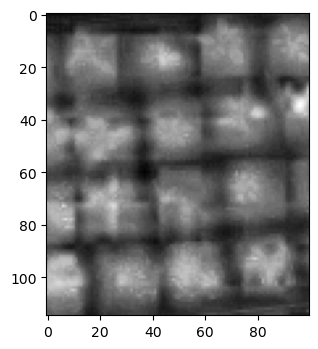

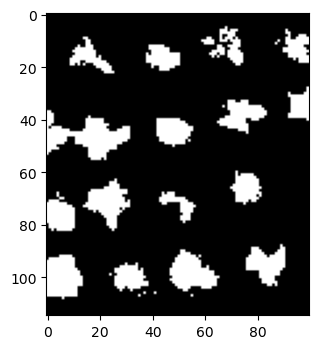

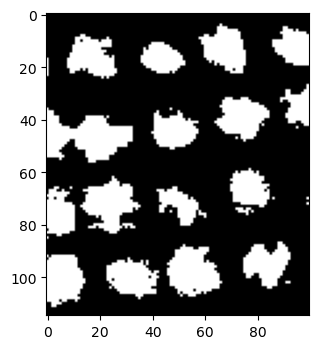

In [13]:
# Convert RGB to LAB and extract the blue channel
#Then threshold the image
b = pcv.rgb2gray_lab(rgb_img=img1, channel='b')
b_thresh = pcv.threshold.binary(gray_img=b, threshold=125, max_value=255, object_type='light')

#Setting threshold continued
b_cnt = pcv.threshold.binary(gray_img=b, threshold=120, max_value=255, object_type='light')


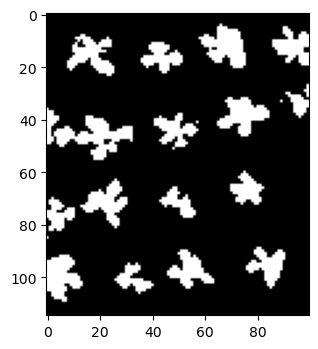

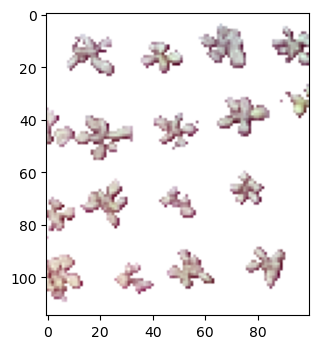

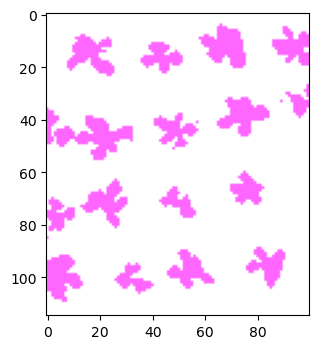

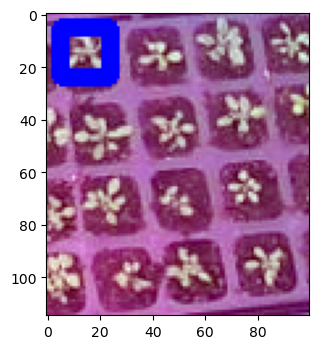

In [14]:
#Join the blue and yellow binary images
bs = pcv.logical_and(bin_img1=s_mblur, bin_img2=b_cnt)

masked = pcv.apply_mask(img=img1, mask=bs, mask_color='white')

#identify objects
obj2 = id_objects,obj_hierarchy = pcv.find_objects(img=masked, mask=bs)

#Define Range of Intrest
# Inputs: 
    #   img - RGB or grayscale image to plot the ROI on 
    #   x - The x-coordinate of the upper left corner of the rectangle 
    #   y - The y-coordinate of the upper left corner of the rectangle 
    #   h - The height of the rectangle 
    #   w - The width of the rectangle 
roi1, roi_hierarchy= pcv.roi.rectangle(img=img1, x=5, y=5, h=20, w=20)

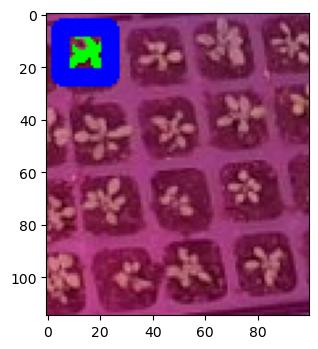

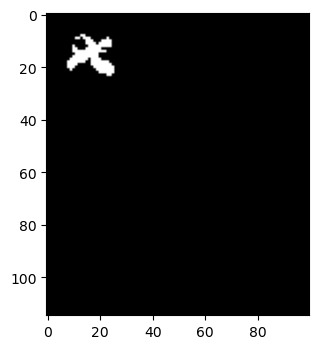

In [15]:
# Decide which objects to keep

    # Inputs:
    #    img            = img to display kept objects
    #    roi_contour    = contour of roi, output from any ROI function
    #    roi_hierarchy  = contour of roi, output from any ROI function
    #    object_contour = contours of objects, output from pcv.find_objects function
    #    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
    #    roi_type       = 'partial' (default, for partially inside), 'cutto', or 
    #    'largest' (keep only largest contour)
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=crop_img, roi_contour=roi1, 
                                                                  roi_hierarchy=roi_hierarchy,
                                                                  object_contour=id_objects,
                                                                  obj_hierarchy=obj_hierarchy,
                                                                  roi_type='LARGEST')

#mine
cropped_mask=kept_mask

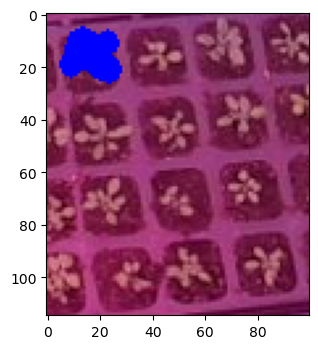

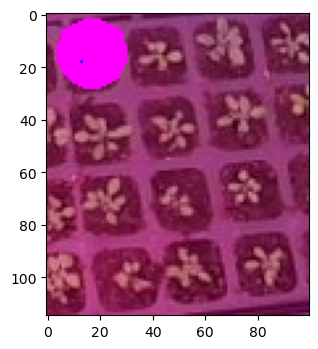

In [16]:
 obj45, mask = pcv.object_composition(img=crop_img, contours=roi_objects, hierarchy=hierarchy)

######## workflow steps here ########

# Find shape properties, output shape image (optional)
shape_img = pcv.analyze_object(crop_img, obj45, cropped_mask)

#pcv.outputs.add_observation(variable='Plant Solidity', trait='Solidity',
#                           method='none', scale='percent', datatype=float,
#value=shape_img, label='percent')

# Look at object area data without writing to a file 
#plant_area = pcv.outputs.observations['Pixels']['value']

In [17]:
import os
import cv2
import numpy as np
from skimage.segmentation import watershed
from plantcv.plantcv import fatal_error
from plantcv.plantcv import outputs
from plantcv.plantcv import color_palette
from plantcv.plantcv import params
from plantcv.plantcv import plot_image
from plantcv.plantcv import print_image


def fill_segments(mask, objects):
    """Fills masked segments from contours.
    Inputs:
    mask         = Binary image, single channel, object = 1 and background = 0
    objects      = List of contours
    Returns:
    filled_img   = Filled mask
    :param mask: numpy.ndarray
    :param object: list
    :return filled_img: numpy.ndarray
    """

    params.device += 1

    h,w = mask.shape
    markers = np.zeros((h,w))

    labels = np.arange(len(objects)) + 1
    for i,l in enumerate(labels):
        cv2.drawContours(markers, objects, i ,int(l) , 5)

    # Fill as a watershed segmentation from contours as markers
    filled_mask = watershed(mask==0, markers=markers,
                            mask=mask!=0,compactness=0)

    # Count area in pixels of each segment
    ids, counts = np.unique(filled_mask, return_counts=True)
    outputs.add_observation(variable='segment_area', trait='segment area',
                            method='plantcv.plantcv.morphology.fill_segments',
                            scale='pixels', datatype=list,
                            value=counts[1:].tolist(),
                            label=(ids[1:]-1).tolist())

    rgb_vals = color_palette(num=len(labels))
    filled_img = np.zeros((h,w,3), dtype=np.uint8)
    for l in labels:
        for ch in range(3):
            filled_img[:,:,ch][filled_mask==l] = rgb_vals[l-1][ch]

    if params.debug == 'print':
        print_image(filled_img, os.path.join(params.debug_outdir, str(params.device) + '_filled_img.png'))
    elif params.debug == 'plot':
        plot_image(filled_img)

    return filled_img

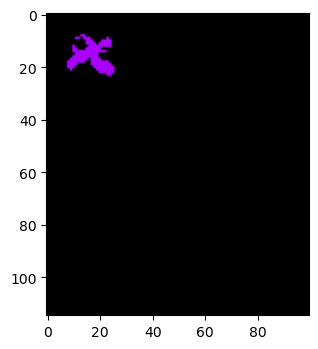

In [18]:
#Area of plant
#Fill in segments (also stores out area data)  

# Inputs:
# mask         = Binary image, single channel, object = 1 and background = 0
# objects      = List of contours
filled_img = fill_segments(mask=cropped_mask, objects=roi_objects)

# Access data stored out from fill_segments
segments_area = pcv.outputs.observations['segment_area']['value']

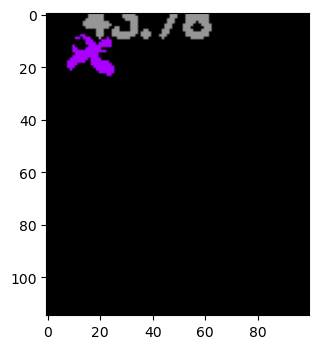

In [19]:
#Length
# Measure path lengths of segments     

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
labeled_img  = pcv.morphology.segment_path_length(segmented_img=filled_img, 
                                                  objects=roi_objects)

In [20]:
# Write morphological data to results file

# The print_results function will take the measurements stored when running any (or all) of these functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.print_results(filename=args.result)


In [388]:
#CLEARS OUTPUTS
#pcv.outputs.clear()